In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display

from cued_sf2_lab.familiarisation import load_mat_img, plot_image

# 12. Combined run-length / Huffman coding methods

<div class="alert alert-warning alert-block">
    
This notebook is incomplete!</div>

Up to this point, we have been using entropy as a measure of the number of bits for the
compressed image.  Now we attempt to produce a vector of compressed image data
which accurately represents the compression that can be achieved in practise.

Huffman codes are relatively
efficient at coding data with non-uniform probability distributions, provided
that the probability of any single event does not exceed 50%.  However, when
an image is transformed by any of the energy compaction methods
considered so far, a high proportion of the quantised coefficients are zero,
so this event usually does have a probability much greater than 50%.  In fact
it is only when this _is_ a high probability event that high compression
can be achieved!  Therefore new ways of using Huffman codes have been
developed to deal with this situation as efficiently as possible.

## 12.1 Baseline JPEG coding techniques

The standard Huffman coding solution, used by the baseline JPEG
specification and most other image compression standards, is to code each
non-zero coefficient combined with the number of zero coefficients which
preceed it as a single event.

For example the sequence of coefficients:
$$
3, 0, 0, -2, 0, 0, 0, 1, 0, -3, -1, 0, 0, 0, 0, 1, \ldots
$$
would be coded as the following 6 events:
```
0 zeros, 3
2 zeros, -2
3 zeros, 1
1 zero, -3
0 zeros, -1
4 zeros, 1
```

Each event has a certain probability (usually well below 50%) and
can be coded efficiently with a standard Huffman code.  As
formulated above, the number of combinations of amplitude and
run-length can be very large, leading to a highly complex code.
JPEG limits this complexity to only 162 combinations by
restricting the maximum run-length to 15 zeros and by coding only
the base-2 logarithm of the amplitude in the Huffman code, rounded
up to integers from 1 to 10.  The sign bit and the remaining
amplitude bits are then appended to the Huffman code word.  16 run lengths (0 to
15) and 10 log amplitudes (1 to 10) give 160 of the code words.
The other two codewords are the end-of-block word (EOB),
signifying no more non-zero coefficients in the current block, and
the run-of-16 word (ZRL), which may be used repetitively ahead of
another codeword for runs of 16 or more zeros.

JPEG is based on $8 \times 8$ DCT transformations of the image, and the data
from each $8 \times 8$ block of DCT coefficients is coded as a block of
Huffman codewords.  First the dc coefficient (top left corner) is coded.
There is little penalty in using a fixed-length binary code for this, although
JPEG uses differential and Huffman coding for slightly improved performance.
Then the remaining 63 ac coefficients are arranged into a linear vector, by
scanning the $8 \times 8$ block in a zig-zag manner corresponding to
progressively increasing frequencies (see the JPEG standard, section 3, fig 5).  This places
the larger low-frequency coefficients close together near the start of the
vector (with short run lengths) and the smaller high-frequency coefficients
spread out towards the end of the vector (with long run lengths).  The
end-of-block word efficiently terminates the coding of each block after the
last non-zero coefficient.

For further details of the JPEG techniques, referred to above, see the JPEG
standard, sections 3.3 and 3.6 and appendices A.3, C, F.1.1, F.1.2, F.2.1,
F.2.2, K.1, K.2, and K.3.  Note that for this project we ignore the higher
layers of the JPEG specification, and do not align code segments with byte
boundaries or use two-byte marker codes to identify different data segments.
JPEG also permits arithmetic codes to be used instead of Huffman codes, but
these are more complicated so we recommend that you should use the latter.


## 12.2 Python implementation of Huffman coding

<div class="alert alert-warning alert-block">
    
This section is **very** incomplete!</div>


The file at `cued_sf2_lab/jpeg.py` contains implementations of the following functions:

* `jpegenc`: perform simplified JPEG encoding of an image `X` into a matrix of variable length codewords `vlc`.
* `jpegdec`: perform simplified JPEG decoding of a codeword matrix `vlc` into an image `Z`.
* `quant1`: quantise a matrix into integers representing the quantiser step numbers, which is the form necessary to allow Huffman coding.
* `quant2`: reconstruct a matrix from integers.  Together with `quant1` this is equivalent to `quantise`.
* `runampl`: convert a vector of coefficients `a` into a matrix of run-length, log-amplitude and signed-remainder values `rsa`.
* `huffenc`: convert a run/amplitude matrix `rsa` into a matrix of variable-length codewords `vlc`.
* `huffdflt`: generate the specification table `hufftab`, for the default JPEG Huffman code tables for AC luminance
or AC chrominance coefficients (JPEG specification, appendix K.3.3.2).
* `huffdes`: design the specification table, `hufftab`, for optimised JPEG Huffman code tables using a histogram of
codeword usage `huffhist`.
* `huffgen`: generate the Huffman code tables, `huffcode` and `ehuf`, from `hufftab`.

In [3]:
from cued_sf2_lab.jpeg import (
    jpegenc, jpegdec, quant1, quant2, huffenc, huffdflt, huffdes, huffgen)

In order to allow relatively fast decoding in Python, we have cheated a
little in the format of the coded data.  Each variable-length codeword is
stored as an integer element of the required word length in the first column
of a 2-column matrix `vlc` and the length of the codeword in bits is
stored next to it in the second column.  We do not bother to pack this data
into a serial bit stream since it is awkward and time consuming to unpack in
Matlab, and we have not got around to changing this now that the lab is in Python!
The length of the bit-stream if it were packed can easily be obtained
from `vlc[:,1].sum()`.

To perform the simplified JPEG encoding, based on the $8 \times 8$ DCT,
load the image in `X` and type:  `vlc, hufftab = jpegenc(X, qstep)`.
You can inspect the codewords with `dict(zip(hufftab.huffval, hufftab.codes))`.

In [4]:
# your code here
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

X = lighthouse.copy()
#X = X - 128  # CANNOT DO THAT FOR jpegenc!!

qstep = 17
vlc, hufftab = jpegenc(X, qstep)


print(vlc[:,1].sum())

#print(dict(zip(hufftab.huffval, hufftab.codes)))|
print(hufftab.huffval)


Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Bits for coded image = 67605
67605
[  1   2   3   0   4  17   5  18  33  49  65   6  19  81  97   7  34 113
  20  50 129 145 161   8  35  66 177 193  21  82 209 240  36  51  98 114
 130   9  10  22  23  24  25  26  37  38  39  40  41  42  52  53  54  55
  56  57  58  67  68  69  70  71  72  73  74  83  84  85  86  87  88  89
  90  99 100 101 102 103 104 105 106 115 116 117 118 119 120 121 122 131
 132 133 134 135 136 137 138 146 147 148 149 150 151 152 153 154 162 163
 164 165 166 167 168 169 170 178 179 180 181 182 183 184 185 186 194 195
 196 197 198 199 200 201 202 210 211 212 213 214 215 216 217 218 225 226
 227 228 229 230 231 232 233 234 241 242 243 244 245 246 247 248 249 250]


This produces variable-length coded data in `vlc`, using quantisation step sizes of qstep.  To decode `vlc`, type:  `Z = jpegdec(vlc, qstep)`

Generating huffcode and ehuf using default tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT



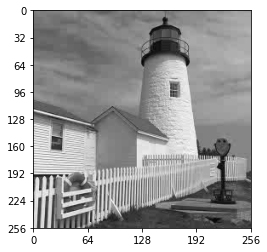

In [5]:
# your code here

Z = jpegdec(vlc, qstep=17) # We don't need hufftab? what is this sorcery
#Z = Z + 128

fig, ax = plt.subplots()
plot_image(Z)

This `jpeg.py` file is given to you as examples of how to achieve a complete compression
system. They have other options and outputs, and in general you will need to copy them to a new
file and modify them to perform your own algorithms.

In `jpegenc`, there are two ways to specify the Huffman
tables: either the default JPEG AC luminance or chrominance tables
may be used; or custom tables may be designed, based on statistics
in the histogram vector `huffhist`. To generate a valid
histogram for `huffdes`, coding must be performed at least
once using `huffdflt` instead, so `jpegenc` is written
such that the default tables are used first and then, if required,
the code is redesigned using custom tables. Note that if it is
planned to use `huffdes` to generate an optimised Huffman code
for each new image to be coded, then the specification tables `hufftab.bits` and `hufftab.huffval` must be sent with the compressed image,
which costs (16 + 162) bytes = 1424 bits.  You should consider
whether or not this is a sensible strategy.

## Going beyond JPEG and the DCT

If you have chosen the DCT as one of your energy compaction
methods then it is fairly straightforward to follow the JPEG
guidelines for coding the coefficients.  However if you have
chosen one of the other methods then a modified scanning strategy is required.

It has already been mentioned that the LBT (which is at the heart of the JPEG-XR standard) is often coded several sub-blocks at a time. We can make a smaller LBT ($4 \times 4$ is the default) look like a $16 \times 16$ DCT by using the `regroup(Yq, 4)` function within each $16 \times 16$ block of `Yq`. The functions `jpegenc` and `jpegdec` have already been written to do this if the `M` argument (which specifies the {\em coding} block size) is larger than the `N` argument (which specifies the DCT block size).

The DWT (which is the basis of the JPEG2000 standard) can also be re-arranged to make it look similar to a DCT. For instance, a 3-level DWT could be re-arranged into an $8 \times 8$ block $B$ using coefficients from the same
square spatial area:


> 4 values from level 3: $B3$ = [$UU_3$ $VU_3$; $UV_3$, $VV_3$]  
> 3 surrounding $2 \times 2$ blocks from level 2: $B2$ = [$B3$ $VU_2$; $UV_2$ $VV_2$]  
> 3 surrounding $4 \times 4$ blocks from level 1: $B$ = [$B2$ $VU_1$; $UV_1$ $VV_1$]

It is not possible to achieve this sort of grouping using the simple `regroup` function, so we have provided a more complicated function 
`dwtgroup(X,n)` which converts an n-level DWT sub-image set into blocks of size $N \times N$ (where $N = 2^n$) with the above type of grouping.  Try this
function on some small regular matrices (e.g. `np.arange(16*16).reshape(16, 16)`) to
see how it works. Note that `dwtgroup(X, -n)` reverses this grouping.

In [6]:
from cued_sf2_lab.jpeg import dwtgroup
# this is a nice trick to get an array of coordinates; use `display(x)` to check what this is doing
i, j = np.indices((8, 8))
x = np.rec.array((i, j))
print(x)
print("\n")
print(dwtgroup(x, 2))

[[(0, 0) (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) (0, 6) (0, 7)]
 [(1, 0) (1, 1) (1, 2) (1, 3) (1, 4) (1, 5) (1, 6) (1, 7)]
 [(2, 0) (2, 1) (2, 2) (2, 3) (2, 4) (2, 5) (2, 6) (2, 7)]
 [(3, 0) (3, 1) (3, 2) (3, 3) (3, 4) (3, 5) (3, 6) (3, 7)]
 [(4, 0) (4, 1) (4, 2) (4, 3) (4, 4) (4, 5) (4, 6) (4, 7)]
 [(5, 0) (5, 1) (5, 2) (5, 3) (5, 4) (5, 5) (5, 6) (5, 7)]
 [(6, 0) (6, 1) (6, 2) (6, 3) (6, 4) (6, 5) (6, 6) (6, 7)]
 [(7, 0) (7, 1) (7, 2) (7, 3) (7, 4) (7, 5) (7, 6) (7, 7)]]


[[(0, 0) (0, 2) (0, 4) (0, 5) (0, 1) (0, 3) (0, 6) (0, 7)]
 [(2, 0) (2, 2) (1, 4) (1, 5) (2, 1) (2, 3) (1, 6) (1, 7)]
 [(4, 0) (4, 1) (4, 4) (4, 5) (4, 2) (4, 3) (4, 6) (4, 7)]
 [(5, 0) (5, 1) (5, 4) (5, 5) (5, 2) (5, 3) (5, 6) (5, 7)]
 [(1, 0) (1, 2) (2, 4) (2, 5) (1, 1) (1, 3) (2, 6) (2, 7)]
 [(3, 0) (3, 2) (3, 4) (3, 5) (3, 1) (3, 3) (3, 6) (3, 7)]
 [(6, 0) (6, 1) (6, 4) (6, 5) (6, 2) (6, 3) (6, 6) (6, 7)]
 [(7, 0) (7, 1) (7, 4) (7, 5) (7, 2) (7, 3) (7, 6) (7, 7)]]



With these modified scanning strategies, the JPEG run-length / log amplitude coding can then be used for each vector in the same way as for the DCT coefficients. However, these scanning strategies are not optimal, and do not represent those outlined in the JPEG2000 and JPEG-XR standards.

You should write versions of `jpegenc` and `jpegdec` for
your chosen compression strategies and check the following:
1. The rms error (standard deviation) between the decoded and original
images should be the same as for the equivalent quantisation
strategies that were tested in the previous section on
centre-clipped linear quantisers.  No extra errors should be
introduced by the scanning or Huffman encode / decode operations.

2. The number of bits required to code an image should be comparable with
the value predicted from the entropy of the quantised coefficients (i.e.
within about 20%).  Note that it is possible to code with fewer bits than
predicted by the entropy because the run-length coding can take advantage of
clustering of non-zero coefficients, which is not taken account of in the
first-order entropy calculations.



# Converting their jpegenc into lbtenc

In [7]:
from simple_lbt_functions import (
    pot, dct, idct, ipot, dct_regroup, dct_reshape, lbt, ilbt, full_process_results)

from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.laplacian_pyramid import bpp

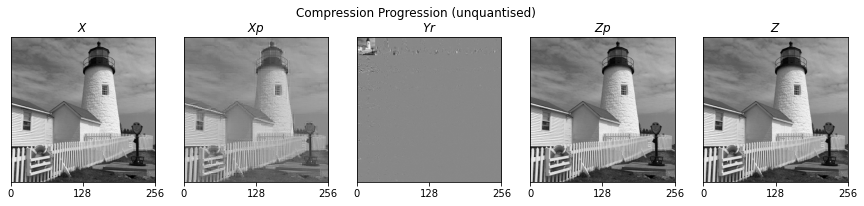

In [8]:
# Compression Progression (Quantised)

# DON"T KNOW WHY THIS DOESN"T WORK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
#X = lighthouse - 128

X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

# Compression Progression (unquantised)
Xp = pot(X, N=8, s=1)
Y = dct(Xp, N=8)
Yr = dct_regroup(Y, N=8)
Zp = idct(Y, N=8)
Z = ipot(Zp, N=8, s=1)



# Plot multiple images
titles = ["X", "Xp", "Yr", "Zp", "Z"]
imgs = [X, Xp, Yr, Zp, Z]
fig, axs = plt.subplots(1, len(imgs), figsize=(15,3))
fig.suptitle("Compression Progression (unquantised)")
for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

RMS = 3.81839562685838
bits = 107400.60632513613
Compression Ratio (wrt X) = 4.593997870804495
Compression Ratio (wrt Xq) = 2.1240013843878853


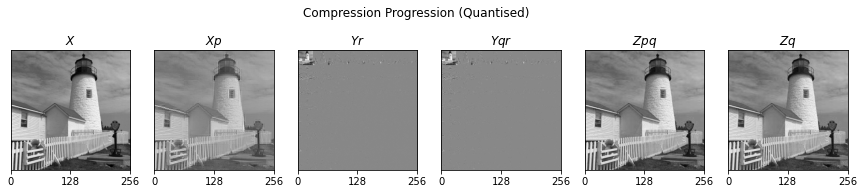

In [9]:
# Compression Progression (Quantised)
Xp = pot(X, N=8, s=1)
Y = dct(Xp, N=8)
Yr = dct_regroup(Y, N=8)
Yrr = dct_reshape(Yr, N=8)

step = 17
Yq = quantise(Y, step)

Yqr = dct_regroup(Yq, N=8)
Yqrr = dct_reshape(Yqr, N=8)
Zpq = idct(Yq, N=8)
Zq = ipot(Zpq, N=8, s=1)

rms = np.std(Zq-X)
bits_Yq = bpp(Yq) * Yq.size
bits_X = bpp(X) * X.size
cr = bits_X / bits_Yq               # cr means compression ratio w.r.t. X from now on!!!!!!!!!!!!!!!!!
print(f"RMS = {rms}")
print(f"bits = {bits_Yq}")
print(f"Compression Ratio (wrt X) = {cr}")
print(f"Compression Ratio (wrt Xq) = {bpp(quantise(X,step))*X.size / bits_Yq}")

# Plot multiple images
titles = ["X", "Xp", "Yr", "Yqr", "Zpq", "Zq"]
imgs = [X, Xp, Yr, Yqr, Zpq, Zq]
fig, axs = plt.subplots(1, len(imgs), figsize=(15,3))
fig.suptitle("Compression Progression (Quantised)")
for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')


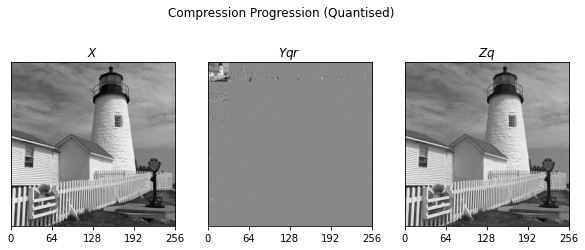

In [10]:
# Compression Progression (Quantised)
Y = lbt(X, N=8, s=1)
step = 17
Yq = quantise(Y, step)
Yqr = dct_regroup(Yq, N=8)
Zq = ilbt(Yq, N=8, s=1)

# Plot multiple images
titles = ["X", "Yqr", "Zq"]
imgs = [X, Yqr, Zq]
fig, axs = plt.subplots(1, len(imgs), figsize=(10,4))
fig.suptitle("Compression Progression (Quantised)")
for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')


# Lottta code, with lbtenc and lbtdec (one line changed for both lmao)

In [11]:
from typing import Tuple, NamedTuple, Optional

import numpy as np
from cued_sf2_lab.laplacian_pyramid import quant1, quant2
from cued_sf2_lab.dct import dct_ii, colxfm, regroup
from cued_sf2_lab.bitword import bitword

In [12]:
def lbtenc(X: np.ndarray, qstep: float, N: int = 8, M: int = 8,
        opthuff: bool = False, dcbits: int = 8, log: bool = True
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    Encodes the image in X to generate a variable length bit stream.

    Parameters:
        X: the input greyscale image
        qstep: the quantisation step to use in encoding
        N: the width of the DCT block (defaults to 8)
        M: the width of each block to be coded (defaults to N). Must be an
            integer multiple of N - if it is larger, individual blocks are
            regrouped.
        opthuff: if true, the Huffman table is optimised based on the data in X
        dcbits: the number of bits to use to encode the DC coefficients
            of the DCT.

    Returns:
        vlc: variable length output codes, where ``vlc[:,0]`` are the codes and
            ``vlc[:,1]`` the number of corresponding valid bits, so that
            ``sum(vlc[:,1])`` gives the total number of bits in the image
        hufftab: optional outputs containing the Huffman encoding
            used in compression when `opthuff` is ``True``.
    '''

    if M % N != 0:
        raise ValueError('M must be an integer multiple of N!')

    # DCT on input image X.
    if log:
        print('Forward {} x {} DCT'.format(N, N))
    C8 = dct_ii(N)
    #Y = colxfm(colxfm(X, C8).T, C8).T ################################################################################################
    Y = lbt(X, N=8, s=1)

    # Quantise to integers.
    if log:
        print('Quantising to step size of {}'.format(qstep))
    Yq = quant1(Y, qstep, qstep).astype('int')

    # Generate zig-zag scan of AC coefs.
    scan = diagscan(M)

    # On the first pass use default huffman tables.
    if log:
        print('Generating huffcode and ehuf using default tables')
    dhufftab = huffdflt(1)  # Default tables.
    huffcode, ehuf = huffgen(dhufftab)

    # Generate run/ampl values and code them into vlc(:,1:2).
    # Also generate a histogram of code symbols.
    if log:
        print('Coding rows')
    sy = Yq.shape
    huffhist = np.zeros(16 ** 2)
    vlc = []
    for r in range(0, sy[0], M):
        for c in range(0, sy[1], M):
            yq = Yq[r:r+M,c:c+M]
            # Possibly regroup
            if M > N:
                yq = regroup(yq, N)
            yqflat = yq.flatten('F')
            # Encode DC coefficient first
            dccoef = yqflat[0] + 2 ** (dcbits-1)
            if dccoef not in range(2**dcbits):
                raise ValueError(
                    'DC coefficients too large for desired number of bits')
            vlc.append(np.array([[dccoef, dcbits]]))
            # Encode the other AC coefficients in scan order
            # huffenc() also updates huffhist.
            ra1 = runampl(yqflat[scan])
            vlc.append(huffenc(huffhist, ra1, ehuf))
    # (0, 2) array makes this work even if `vlc == []`
    vlc = np.concatenate([np.zeros((0, 2), dtype=np.intp)] + vlc)

    # Return here if the default tables are sufficient, otherwise repeat the
    # encoding process using the custom designed huffman tables.
    if not opthuff:
        if log:
            print('Bits for coded image = {}'.format(sum(vlc[:, 1])))
        return vlc, dhufftab

    # Design custom huffman tables.
    if log:
        print('Generating huffcode and ehuf using custom tables')
    dhufftab = huffdes(huffhist)
    huffcode, ehuf = huffgen(dhufftab)

    # Generate run/ampl values and code them into vlc(:,1:2).
    # Also generate a histogram of code symbols.
    if log:
        print('Coding rows (second pass)')
    huffhist = np.zeros(16 ** 2)
    vlc = []
    for r in range(0, sy[0], M):
        for c in range(0, sy[1], M):
            yq = Yq[r:r+M, c:c+M]
            # Possibly regroup
            if M > N:
                yq = regroup(yq, N)
            yqflat = yq.flatten('F')
            # Encode DC coefficient first
            dccoef = yqflat[0] + 2 ** (dcbits-1)
            vlc.append(np.array([[dccoef, dcbits]]))
            # Encode the other AC coefficients in scan order
            # huffenc() also updates huffhist.
            ra1 = runampl(yqflat[scan])
            vlc.append(huffenc(huffhist, ra1, ehuf))
    # (0, 2) array makes this work even if `vlc == []`
    vlc = np.concatenate([np.zeros((0, 2), dtype=np.intp)] + vlc)

    if log:
        print('Bits for coded image = {}'.format(sum(vlc[:, 1])))
        print('Bits for huffman table = {}'.format(
            (16 + max(dhufftab.huffval.shape))*8))

    return vlc, dhufftab

In [13]:
class HuffmanTable(NamedTuple):
    """A huffman table stored in sorted order
    
    Attributes:
        bits: The number of values per bit level, shape ``(16,)``.
        huffval: The codes sorted by bit length, shape ``(162,)``.
    """
    bits: np.ndarray
    huffval: np.ndarray

    @property
    def codes(self) -> np.ndarray:
        """ Produce an array of codewords corresponding to the requested bit lengths"""
        ncodes = len(self.huffval)
        if np.sum(self.bits) != ncodes:
            raise ValueError("bits and huffvals disagree")

        # Generate huffman size table (JPEG fig C1, p78):
        k = 0
        huffsize = np.zeros(ncodes, dtype=int)
        for i, b in enumerate(self.bits):
            huffsize[k:k+b] = i + 1
            k += b

        huffcode = np.zeros(ncodes, dtype=int)
        code = 0
        si = huffsize[0]

        # Generate huffman code table (JPEG fig C2, p79)
        for k in range(ncodes):
            while huffsize[k] > si:
                code = code * 2
                si += 1
            huffcode[k] = code
            code += 1

        huff_bitwords = np.zeros(ncodes, dtype=bitword.dtype)
        huff_bitwords['val'] = huffcode
        huff_bitwords['bits'] = huffsize
        return huff_bitwords

def HuffmanTable__new__(cls, bits, huffval):
    assert len(huffval) == sum(bits)
    return super(cls, HuffmanTable).__new__(cls, (bits, huffval))

HuffmanTable.__new__ = HuffmanTable__new__

In [14]:
def lbtdec(vlc: np.ndarray, qstep: float, N: int = 8, M: int = 8,
        hufftab: Optional[HuffmanTable] = None,
        dcbits: int = 8, W: int = 256, H: int = 256, log: bool = True
        ) -> np.ndarray:
    '''
    Decodes a (simplified) JPEG bit stream to an image

    Parameters:

        vlc: variable length output code from jpegenc
        qstep: quantisation step to use in decoding
        N: width of the DCT block (defaults to 8)
        M: width of each block to be coded (defaults to N). Must be an
            integer multiple of N - if it is larger, individual blocks are
            regrouped.
        hufftab: if supplied, these will be used in Huffman decoding
            of the data, otherwise default tables are used
        dcbits: the number of bits to use to decode the DC coefficients
            of the DCT
        W, H: the size of the image (defaults to 256 x 256)

    Returns:

        Z: the output greyscale image
    '''

    opthuff = (hufftab is not None)
    if M % N != 0:
        raise ValueError('M must be an integer multiple of N!')

    # Set up standard scan sequence
    scan = diagscan(M)

    if opthuff:
        if len(hufftab.bits.shape) != 1:
            raise ValueError('bits.shape must be (len(bits),)')
        if log:
            print('Generating huffcode and ehuf using custom tables')
    else:
        if log:
            print('Generating huffcode and ehuf using default tables')
        hufftab = huffdflt(1)
    # Define starting addresses of each new code length in huffcode.
    # 0-based indexing instead of 1
    huffstart = np.cumsum(np.block([0, hufftab.bits[:15]]))
    # Set up huffman coding arrays.
    huffcode, ehuf = huffgen(hufftab)

    # Define array of powers of 2 from 1 to 2^16.
    k = 2 ** np.arange(17)

    # For each block in the image:

    # Decode the dc coef (a fixed-length word)
    # Look for any 15/0 code words.
    # Choose alternate code words to be decoded (excluding 15/0 ones).
    # and mark these with vector t until the next 0/0 EOB code is found.
    # Decode all the t huffman codes, and the t+1 amplitude codes.

    eob = ehuf[0]
    run16 = ehuf[15 * 16]
    i = 0
    Zq = np.zeros((H, W))

    if log:
        print('Decoding rows')
    for r in range(0, H, M):
        for c in range(0, W, M):
            yq = np.zeros(M**2)

            # Decode DC coef - assume no of bits is correctly given in vlc table.
            cf = 0
            if vlc[i, 1] != dcbits:
                raise ValueError(
                    'The bits for the DC coefficient does not agree with vlc table')
            yq[cf] = vlc[i, 0] - 2 ** (dcbits-1)
            i += 1

            # Loop for each non-zero AC coef.
            while np.any(vlc[i] != eob):
                run = 0

                # Decode any runs of 16 zeros first.
                while np.all(vlc[i] == run16):
                    run += 16
                    i += 1

                # Decode run and size (in bits) of AC coef.
                start = huffstart[vlc[i, 1] - 1]
                res = hufftab.huffval[start + vlc[i, 0] - huffcode[start]]
                run += res // 16
                cf += run + 1
                si = res % 16
                i += 1

                # Decode amplitude of AC coef.
                if vlc[i, 1] != si:
                    raise ValueError(
                        'Problem with decoding .. you might be using the wrong hufftab table')
                ampl = vlc[i, 0]

                # Adjust ampl for negative coef (i.e. MSB = 0).
                thr = k[si - 1]
                yq[scan[cf-1]] = ampl - (ampl < thr) * (2 * thr - 1)

                i += 1

            # End-of-block detected, save block.
            i += 1

            yq = yq.reshape((M, M)).T

            # Possibly regroup yq
            if M > N:
                yq = regroup(yq, M//N)
            Zq[r:r+M, c:c+M] = yq

    if log:
        print('Inverse quantising to step size of {}'.format(qstep))

    Zi = quant2(Zq, qstep, qstep)

    if log:
        print('Inverse {} x {} DCT\n'.format(N, N))
    C8 = dct_ii(N)
    #Z = colxfm(colxfm(Zi.T, C8.T).T, C8.T) ###################################################################################################
    Zq = ilbt(Zi, N=8, s=1) 

    return Z

# Testing:

In [15]:
# your code here
from cued_sf2_lab.jpeg import *

X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

qstep = 17
vlc, hufftab = lbtenc(X, qstep,opthuff=True)


print(vlc[:,1].sum())

#print(dict(zip(hufftab.huffval, hufftab.codes)))|
print(hufftab.huffval)




Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 61963
Bits for huffman table = 1424
61963
[  1   0   2   3  17   4  18  33  49  65  19  34  81  97 113   5  20  50
  66 129 145 161 177 240  35  51  82  98 114 130 193 209  67  83  99 115
 146 147 162 178 179 194 225 241   6  21  36  52  68 163 180 210  37  53
 100 116 131 132 148 195 196 211 226 133 197   7   8   9  10  22  23  24
  25  26  38  39  40  41  42  54  55  56  57  58  69  70  71  72  73  74
  84  85  86  87  88  89  90 101 102 103 104 105 106 117 118 119 120 121
 122 134 135 136 137 138 149 150 151 152 153 154 164 165 166 167 168 169
 170 181 182 183 184 185 186 198 199 200 201 202 212 213 214 215 216 217
 218 227 228 229 230 231 232 233 234 242 243 244 245 246 247 248 249 250]


In [16]:

Z = lbtdec(vlc, qstep=17) # We don't need hufftab? what is this sorcery
#Z = Z + 128

fig, ax = plt.subplots()
plot_image(Z)

Generating huffcode and ehuf using default tables
Decoding rows


ValueError: Problem with decoding .. you might be using the wrong hufftab table